<a href="https://colab.research.google.com/github/shreyas269/programming/blob/master/machine_learning/MNIST_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from torchvision import datasets, transforms

In [0]:
# Hyperparameters
std = np.array((0.5, 0.5, 0.5))
mean = np.array((0.5, 0.5, 0.5))
epochs = 20
training_batch_size = 100
validation_batch_size = 100
lrn_rate = 0.0001

In [0]:
# Declaring and assigning Hyperparameters in a namedtuple
HParams = namedtuple('HPS', 'std, mean, epochs, training_batch_size, validation_batch_size, lrn_rate')
hps = HParams(std=std, mean=mean, epochs=epochs, training_batch_size=training_batch_size, validation_batch_size=validation_batch_size, lrn_rate=lrn_rate)

In [0]:
# In PyTorch, images are represented as [channels, height, width]
# For a 256x256 coloured image, [channels, height, width] = [3, 256, 256]
# For grayscale, channels=1

# "transforms" are common image transformations
# tansforms.Compose chains together transformations
# ToTensor() converts numpy array (PIL image) to FloatTensor in range [0.0, 1.0]. Transforms numpy [H, W, C] to Tensor [C, H, W]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]) # Only one channel to normalize since MNIST is greyscale
# This maps image FloatTensor values from [0.0, 1.0] to [-1.0, 1.0]

In [0]:
training_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
validation_dataset = datasets.MNIST(root='./data', download=True, train=False, transform=transform)
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
# tensor.detach() creates a tensor that shares storage with tensor that does not require grad, i.e. detaches output from computation graph.

# Converts tensor image to numpy
def im_convert(tensor):
  image = tensor.clone().detach().numpy() # Is now [C, H, W]
  image = image.transpose(1, 2, 0) # Is now [H, W, C]

  # Denormalize the image
  # 1. Convert [-1, 1] to [0, 1]

  print(image.shape)
  
  image = image * std + mean
  image.clip(0, 1) # To ensure image value is between [0, 1]

  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


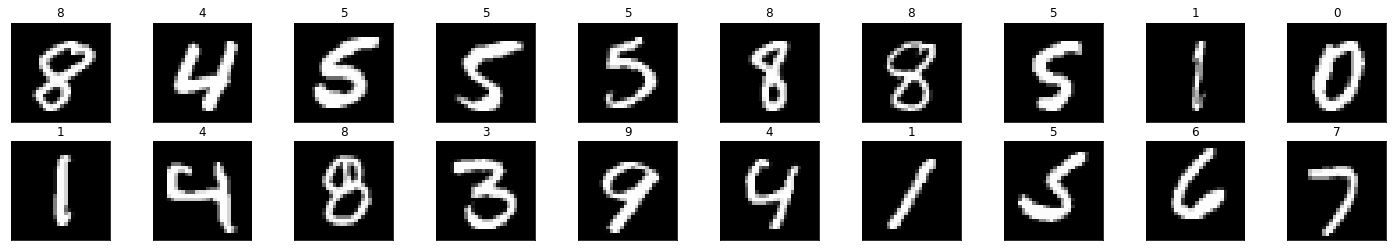

In [0]:
# Provides an iterable over the given dataset as per the sampler provided (optional). Set shuffle=True for default random sampler.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=hps.training_batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=hps.validation_batch_size, shuffle=False)

data_iter = iter(training_loader)
images, labels = data_iter.next() # Grabs first batch of data

# show sampled training images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
# NN Class model
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__() # To inherit all methods from parent class

    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    # Defining architecture of NN
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [0]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD, Adam etc)
optimizer = torch.optim.Adam(model.parameters(), lr=hps.lrn_rate)

In [0]:
def pred_image_loader(loader):
  for inputs, labels in loader:
    inputs = inputs.view(inputs.shape[0], -1) # (1, 28, 28) -> (1, 784). The "-1" infers the remaining value automatically.
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [0]:
def run_image_loader(loader, train):
  running_loss = 0.0  # Accumulates loss from all training examples in the batch
  running_corrects = 0.0 # Accumulates accuracy from all training examples in the batch

  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in loader:
    inputs = inputs.view(inputs.shape[0], -1) # (1, 28, 28) -> (1, 784). The "-1" infers the remaining value automatically.
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if(train==True):
      # Zero the gradients to avoid accumulation
      optimizer.zero_grad()

      # Find the gradient values
      loss.backward()

      # Optimize the parameter values by subtracting lr*gradient
      optimizer.step()

    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [0]:
running_loss_history = [] # List containing training Loss values of a batch in every epoch
running_accuracy_history = [] # List containing training accuracy values of a batch in every epoch

val_running_loss_history = [] # List containing validation Loss values of a batch in every epoch
val_running_accuracy_history = [] # List containing validation accuracy values of a batch in every epoch

for e in range(hps.epochs):
  running_loss, running_corrects = run_image_loader(training_loader, True)

  with torch.no_grad(): # No need for gradients while predicting on validation set
      val_running_loss, val_running_corrects = run_image_loader(validation_loader, False)

  epoch_loss = running_loss/len(training_loader) # epoch_loss is average loss of input example
  epoch_accuracy = running_corrects.float()/len(training_loader) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  running_loss_history.append(epoch_loss)
  running_accuracy_history.append(epoch_accuracy)

  val_epoch_loss = val_running_loss/len(validation_loader) # epoch_loss is average loss of input example
  val_epoch_accuracy = val_running_corrects.float()/len(validation_loader) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  val_running_loss_history.append(val_epoch_loss)
  val_running_accuracy_history.append(val_epoch_accuracy)

  print("epoch: {}, training loss: {:.4f}, training accuracy: {:.4f}, validation loss: {:.4f}, validation accuracy: {:.4f}".format(e+1, epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1, training loss: 0.9464, training accuracy: 78.2667, validation loss: 0.4206, validation accuracy: 88.6600
epoch: 2, training loss: 0.3757, training accuracy: 89.4450, validation loss: 0.3144, validation accuracy: 91.0000
epoch: 3, training loss: 0.3121, training accuracy: 91.0083, validation loss: 0.2792, validation accuracy: 92.0200
epoch: 4, training loss: 0.2780, training accuracy: 91.9467, validation loss: 0.2567, validation accuracy: 92.6900
epoch: 5, training loss: 0.2520, training accuracy: 92.7550, validation loss: 0.2358, validation accuracy: 93.1800
epoch: 6, training loss: 0.2300, training accuracy: 93.4267, validation loss: 0.2161, validation accuracy: 93.8100
epoch: 7, training loss: 0.2121, training accuracy: 93.8783, validation loss: 0.2008, validation accuracy: 94.1900
epoch: 8, training loss: 0.1956, training accuracy: 94.3850, validation loss: 0.1885, validation accuracy: 94.4100
epoch: 9, training loss: 0.1823, training accuracy: 94.7767, validation loss: 0.

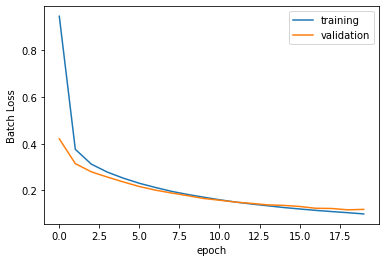

In [0]:
plt.plot(running_loss_history, label='training')
plt.plot(val_running_loss_history, label='validation')
plt.ylabel('Batch Loss')
plt.xlabel('epoch')
plt.legend()

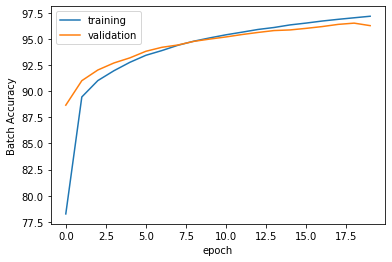

In [0]:
plt.plot(running_accuracy_history, label='training')
plt.plot(val_running_accuracy_history, label='validation')
plt.ylabel('Batch Accuracy')
plt.xlabel('epoch')
plt.legend()